In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from root_pandas import read_root
%run functions.ipynb
%run constants.ipynb

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
Welcome to JupyROOT 6.14/06


In [8]:
def getData(inputFiles):
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('pt_jet')
    scalar.append('eta_jet')
    scalar.append('phi_jet')
    scalar.append('p_jet')
    scalar.append('pt_jet_g')
    scalar.append('pt_quark')
    scalar.append('eta_quark')
    scalar.append('phi_quark')
    scalar.append('pt_photon')
    scalar.append('phi_photon')
    scalar.append('eta_electron')
    scalar.append('pt_electron')
    scalar.append('zg')
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [9]:
files = ["$HOME/EIC/output/102.root"]
a = getData(files)


Processed $HOME/EIC/output/102.root in 80.5 seconds


In [10]:
files = ["$HOME/EIC/output/105.root"]
a2 = getData(files)


Processed $HOME/EIC/output/105.root in 72.7 seconds


In [11]:
def applyCuts(df_array):
    new_df_array = []
    for i in range(0,len(df_array)):
        print "\n" + "dataframe " + str(i) + "\n"
        d = df_array[i]
        d = applyCut(d, 'Q2 > 10', 'Q2 > 10')
        d = applyCut(d, 'y > 0.1 and y < 0.85', '0.1 < y < 0.85')
        d = applyCut(d, 'p_jet > 5', 'p_jet > 5')
        d = applyCut(d, 'W2 > 4', 'W2 > 4')
        d = fixPhi(d, 'photon')
        d = applyCut(d, 'delta_phi_photon_abs < 0.4', 'delta_phi_photon_abs < 0.4')
        d.eval('dpt = pt_jet - pt_jet_g', inplace=True)
        new_df_array.append(d)
    return new_df_array

In [12]:
new_df = applyCuts([a,a2])


dataframe 0

Q2 > 10 3982888  fraction kept: 11.0
0.1 < y < 0.85 2277556  fraction kept: 57.2
p_jet > 5 558256  fraction kept: 24.5
W2 > 4 558256  fraction kept: 100.0
Fixed photon phi range
Fixed photon delta phi range
delta_phi_photon_abs < 0.4 235790  fraction kept: 42.2

dataframe 1

Q2 > 10 3982888  fraction kept: 11.0
0.1 < y < 0.85 2277556  fraction kept: 57.2
p_jet > 5 558256  fraction kept: 24.5
W2 > 4 558256  fraction kept: 100.0
Fixed photon phi range
Fixed photon delta phi range
delta_phi_photon_abs < 0.4 235790  fraction kept: 42.2


In [13]:
ptedges = toArrayFloat(0, 1.55, 0, log=True, logNum=10)
new_ds = []
for new_d in new_df:
    new_ds.append(partitionEtaPt(new_d, [-4.5, 4.5], ptedges))


-4.5 < eta_jet < 4.5 

-4.5 < eta_jet < 4.5 235790  fraction kept: 100.0
1.0 < pt_jet < 1.4866961686809572 14297  fraction kept: 6.1
1.4866961686809572 < pt_jet < 2.2102654979706373 17897  fraction kept: 7.6
2.2102654979706373 < pt_jet < 3.285993247600654 32736  fraction kept: 13.9
3.285993247600654 < pt_jet < 4.885273571519389 47905  fraction kept: 20.3
4.885273571519389 < pt_jet < 7.262917501736213 57167  fraction kept: 24.2
7.262917501736213 < pt_jet < 10.797751623277094 25858  fraction kept: 11.0
10.797751623277094 < pt_jet < 16.052975968694643 9845  fraction kept: 4.2
16.052975968694643 < pt_jet < 23.865897868585808 2681  fraction kept: 1.1
23.865897868585808 < pt_jet < 35.48133892335755 290  fraction kept: 0.1

-4.5 < eta_jet < 4.5 

-4.5 < eta_jet < 4.5 235790  fraction kept: 100.0
1.0 < pt_jet < 1.4866961686809572 14297  fraction kept: 6.1
1.4866961686809572 < pt_jet < 2.2102654979706373 17897  fraction kept: 7.6
2.2102654979706373 < pt_jet < 3.285993247600654 32736  fraction 

In [14]:
ds1, ds2 = new_ds

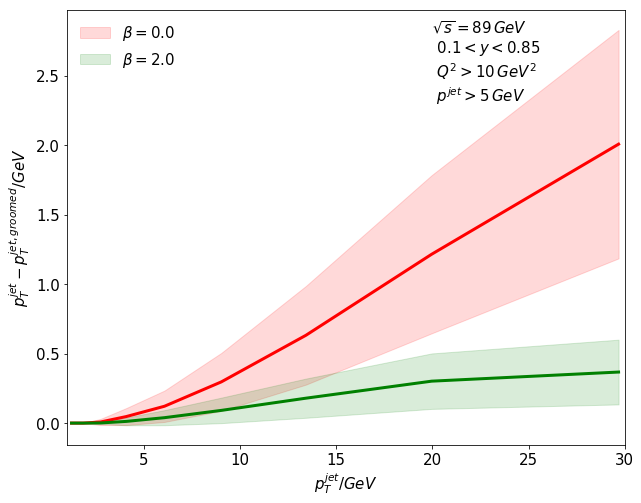

In [20]:
df_array = [ds1, ds2]
var_array = ['dpt','dpt']
color_array = ['r','g']
label_array = [r'$\beta=0.0$',r'$\beta=2.0$']

fig = plt.figure(figsize=(10,8))
x = []*(len(ptedges)-1)
xerr = getInterval(ptedges)/2
for i in range(0,len(var_array)):
    y = []*(len(ptedges)-1)
    yerr = []*(len(ptedges)-1)
    for j in range(len(ptedges)-1):
        var = df_array[i][0][j][var_array[i]]
        if i == 0:
            x.append((((float)(ptedges[j])) + ptedges[j+1])/2)
        y.append(np.mean(var))
        yerr.append(np.std(var)/2)
    plt.plot(x, y, color=color_array[i], linewidth=3)
    plt.fill_between(x, np.array(y)+np.array(yerr), np.array(y)-np.array(yerr), color=color_array[i],\
                     alpha=0.15, label=label_array[i])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$p_T^{jet} / GeV$', fontsize=15)
plt.ylabel('$p_T^{jet} - p_T^{jet,groomed} / GeV$', fontsize=15)
plt.xlim(left=1, right=30)
plt.legend(prop={'size': 15}, frameon=False, loc='upper left')
plt.text(20, 2.3, '$\sqrt{s} = 89 \, GeV$ \n $0.1 < y < 0.85$ \n $Q^2 > 10 \, GeV^2$ \n $p^{jet} > 5 \, GeV$', fontsize=15)
plt.savefig('images/dpt.pdf', bbox_inches='tight')